In [9]:
import io
import pathlib

import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

seaborn.set()
%matplotlib inline


# NAP history

This notebook analyses the history of the Dutch Ordnance Datum (NAP). This is an analysis of the unpublished history of the measurements of the NAP. 
The datasets are derived from different levellings and therefor not unambiguously interpretable. The quality of the measurements can vary and no information about the quality is present. 

The NAP was revised in 2005. The reference level was revised with several centimeters, varying over the Netherlands. The project-ID shows if a measurement was taken before or after the revision. Measurements after 2005 are from the revised level. Some projects have both a revised and unrevised data. Projects with an ‘=’ mark are relative to the revised level. For example: 
Project-ID  370W26 old NAP.
Project-ID  370=26=NAP  same project in revised NAP.


In [13]:
# this is the file that was delivered by Rijkswaterstaat
path = pathlib.Path('../../../data/rws/nap/historie/NAP_Historie.txt')
# open the file
stream = path.open()
# print the first few lines
print("".join(stream.readlines()[:5]))

+----------+-----------+-----------+----------+------------------------------------------------------------+-------------------------+-----------+
|ID        |x          |y          |project_id|titel                                                       |datum                    |NAP hoogte |
+----------+-----------+-----------+----------+------------------------------------------------------------+-------------------------+-----------+
|000A1011  | 163880.630| 540553.300|279H04    |HYDRO SCHARNEGOUTUM                                         |01-may-1986              |      5.121|
|000A1011  | 163880.630| 540553.300|332=04=NAP|SEC herziening 332w04 groningen friesland 1993              |28-jun-1993              |      5.122|



In [27]:
# cleanup lines
lines = []
for i, line in enumerate(path.open()):
    if i in (0, 2):
        continue
    fields = line.split('|')
    fields = [field.strip().strip('|') for field in fields]
    # remove first and last column
    assert fields[0] == '' and fields[-1] == ''
    fields = fields[1:-1]
    line = "|".join(fields)
    lines.append(line)
txt = "\n".join(lines)

In [28]:
df = pd.read_csv(io.StringIO(txt), sep='|', dtype={
    'titel': str,
    'x': float,
    'y': float
})
df['titel'] = df['titel'].astype(str)

df['date'] = df['datum'].apply(lambda x: dateutil.parser.parse(x))
def is_revised(row):
    if row['date'].year >= 2005:
        return True
    if '=' in row['project_id']:
        return True
    return False
df['revised'] = df.apply(is_revised, axis=1)

In [29]:
df.head()

,ID,x,y,project_id,titel,datum,NAP hoogte,date,revised
0,000A1011,163880.63,540553.3,279H04,HYDRO SCHARNEGOUTUM,01-may-1986,5.121,1986-05-01,False
1,000A1011,163880.63,540553.3,332=04=NAP,SEC herziening 332w04 groningen friesland 1993,28-jun-1993,5.122,1993-06-28,True
2,000A1011,163880.63,540553.3,330=01=NAP,SEC herziening 330w01 noord holland 1991,27-feb-1991,5.122,1991-02-27,True
3,000A1011,163880.63,540553.3,332W04,GRONINGEN+FRIESLAND,01-sep-1993,5.121,1993-09-01,False
4,000A1011,163880.63,540553.3,PR3.57,3E NAUWK WP 1950-59,01-jan-1957,5.121,1957-01-01,False


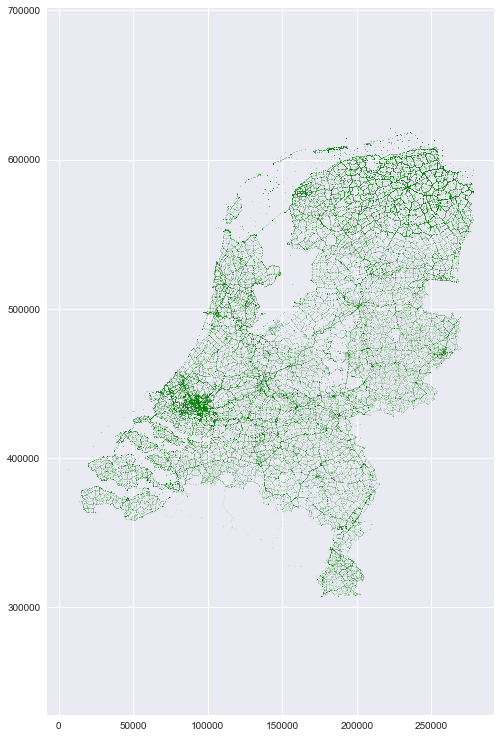

In [8]:
fig, ax = plt.subplots(figsize=(8, 13))
ax.axis('equal')
ax.plot(df['x'], df['y'], 'g.', alpha=0.1, markersize=1);

In [9]:
grouped = df.groupby(('ID', 'x', 'y'))

(442000, 446000)

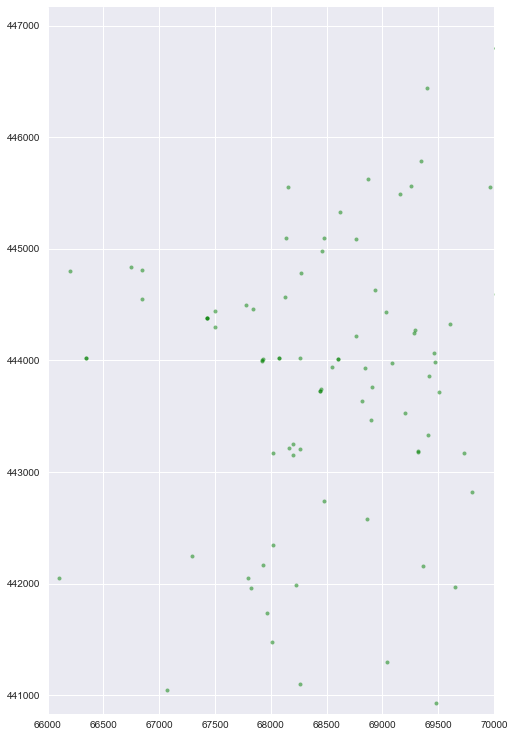

In [10]:
fig, ax = plt.subplots(figsize=(8, 13))
ax.axis('equal')
xy = np.array([it[1:] for it in grouped.indices])
ax.plot(xy[:, 0], xy[:, 1], 'g.', alpha=0.5, markersize=8)
ax.set_xlim(66000, 70000)
ax.set_ylim(442000, 446000)

In [11]:
hvh = df.ix[np.logical_and.reduce([
    df.x > 66000,
    df.x < 70000,
    df.y > 442000,
    df.y < 446000
])]

/Users/baart_f/.virtualenvs/main/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


(-0.1, 0.1)

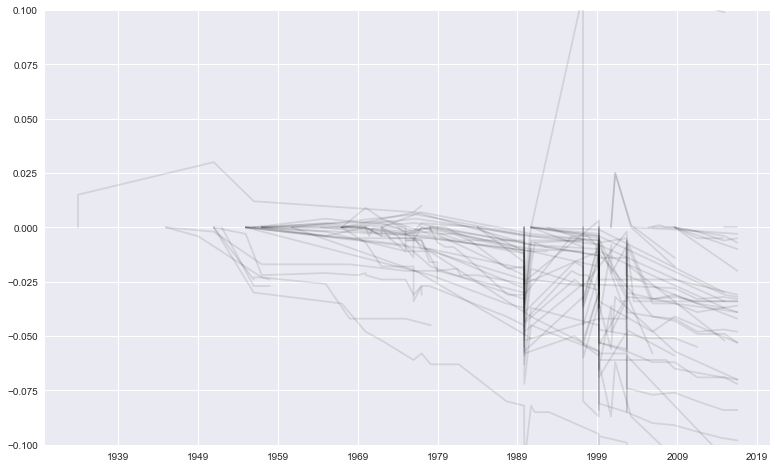

In [12]:
fig, ax = plt.subplots(figsize=(13, 8))
for it, df_group in iter(hvh.groupby(('ID', 'x', 'y'))):
    df_group = df_group.sort_values('date')
    dates = [x.to_pydatetime() for x in df_group.date]
    hoogtes = df_group['NAP hoogte']
    hoogtes_0 = hoogtes - hoogtes.iloc[0]
    ax.plot(dates, hoogtes_0, 'k-', alpha=0.1)
ax.set_ylim(-0.1, 0.1)

    

In [38]:
import ipywidgets
import functools

In [68]:
ids = list(set(df.ID))
def plot(val=(0, len(ids))):
    selection = df[df.ID==ids[val]]
    plt.plot([x.to_pydatetime() for x in selection.date], selection['NAP hoogte'], 'k.')
ipywidgets.interact(plot);


interactive(children=(IntSlider(value=38517, description='val', max=77034), Output()), _dom_classes=('widget-interact',))

In [107]:
import matplotlib.cm
import matplotlib.colors


import pycpt
cmap = pycpt.load.cmap_from_cptcity_url('oc/sst.cpt')

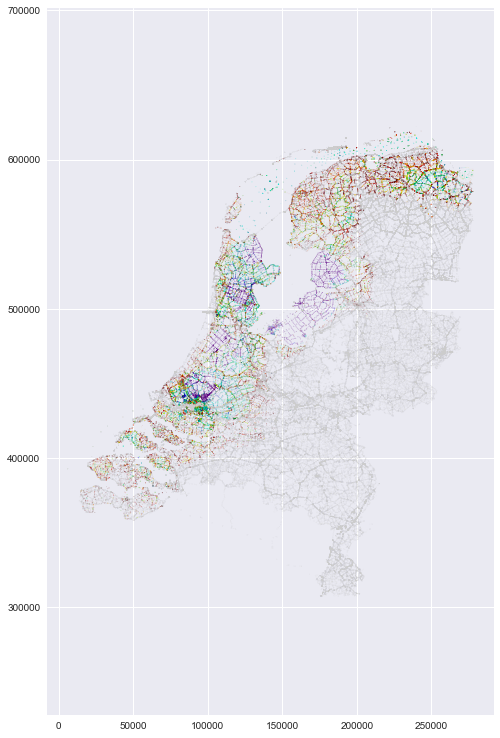

In [109]:
N = matplotlib.colors.Normalize(-2, 2)
selection = df.ix[df['date'] < pd.Timestamp(year=2000, month=1, day=1)]
colors = cmap(N(selection['NAP hoogte'].values), alpha=0.1)
fig, ax = plt.subplots(figsize=(8, 13))
ax.axis('equal')
ax.scatter(selection['x'], selection['y'], c=colors, edgecolors='none', s=1)


Timestamp('2000-01-01 00:00:00')